In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import warnings
import re
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_rows', 80)

df = pd.read_csv("car_age_0_updated_dataset.csv", low_memory=False)
print(f"Initial shape: {df.shape}")

counts = df['od_claim_count'].value_counts().sort_index()
print(counts)

df['policy_start_date'] = pd.to_datetime(df['policy_start_date'])
start_date = df['policy_start_date'].min()
end_date = df['policy_start_date'].max()

print(f"Start date: {start_date}")
print(f"End date:   {end_date}")

print("\n Data Types")
with pd.option_context('display.max_rows', None):
    df.info()

print("\n Top Missing Value Columns")
missing_percent = (df.isnull().sum() / len(df)) * 100
print(missing_percent.sort_values(ascending=False).head(15))

print("\n Numerical Feature Summary")
with pd.option_context('display.max_rows', None, 'display.float_format', '{:,.2f}'.format):
    print(df.describe(include='number').transpose())

Initial shape: (82994, 57)
od_claim_count
0.0000    61784
1.0000    15169
2.0000     4498
3.0000     1092
4.0000      315
5.0000       85
6.0000       31
7.0000       11
8.0000        6
9.0000        3
Name: count, dtype: int64
Start date: 2018-09-10 00:00:00
End date:   2025-09-30 00:00:00

 Data Types
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82994 entries, 0 to 82993
Data columns (total 57 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Unnamed: 0                  82994 non-null  int64         
 1   base_policy                 82994 non-null  object        
 2   od_claim_count              82994 non-null  float64       
 3   car_age                     82994 non-null  float64       
 4   experian_rank_final         77375 non-null  float64       
 5   quarterly_service           37 non-null     float64       
 6   pps_mapped                  81321 non-null  float64       
 7   norma

In [2]:
# 1. Preprocessing + Feature Engineering

# 1a. Drop columns
missing_percent = (df.isnull().sum() / len(df)) * 100
cols_mostly_empty = missing_percent[missing_percent > 70].index.tolist()
unique_counts = df.nunique()
cols_single_value = unique_counts[unique_counts == 1].index.tolist()

cols_to_drop = list(set(cols_mostly_empty + cols_single_value))

cols_to_drop.extend([
    'Unnamed: 0', 
    'policy_start_period', 
    'policy_start_year', 
    'user_agent', 
    'device_vendor_category',
    'base_policy',           
    'recommended_idv',
    'previous_policy_expired',
    'policy_start_month',
    'policy_created_on',
    'cc',
    'model',
    'make',
    'ex_showroom_price',
    'customer_age',
    'exposure_calculated', 
    'variant_bracket',
    'customer_age_group_ordinal',
    'is_rsa',
    'intermediary_id', 
    'Status2'
])

key_cols = ['od_claim_count', 'exposure', 'policy_start_date']
cols_to_drop = [col for col in cols_to_drop if col not in key_cols]

df_cleaned = df.drop(columns=cols_to_drop)
print(f"Shape after dropping columns: {df_cleaned.shape}")

# 1b. Sanitize Feature Names
original_cols = df_cleaned.columns.tolist()
sanitized_cols = [re.sub(r'[^A-Za-z0-9_]+', '_', col) for col in original_cols]
df_cleaned.columns = sanitized_cols

renamed_cols_dict = {orig: new for orig, new in zip(original_cols, sanitized_cols) if orig != new}
if renamed_cols_dict:
    print("Renamed columns:")
    for orig, new in renamed_cols_dict.items():
        print(f"  '{orig}'  =>  '{new}'")

# 1c. Handle date Column
DATE_COL_NAME = 'policy_start_date'
df_cleaned[DATE_COL_NAME] = pd.to_datetime(df_cleaned[DATE_COL_NAME])

# 1d. Define Feature, Target, and Weight
TARGET = 'od_claim_count'
WEIGHT = 'exposure'
DATE_COL = 'policy_start_date'
features = [col for col in df_cleaned.columns if col not in [TARGET, WEIGHT, DATE_COL]]

# 1e. Handle Categorical Features & NaNs
categorical_features = df_cleaned[features].select_dtypes(include=['object', 'category']).columns.tolist()

for col in categorical_features:
    df_cleaned[col] = df_cleaned[col].astype('category')

# 1f. Print Feature Lists
print(f"\nFinal Features for Model Training ({len(features)})")
numerical_features = df_cleaned[features].select_dtypes(include=np.number).columns.tolist()
print(f"\nNumerical Features ({len(numerical_features)}):")
for col in numerical_features:
    print(f"  - {col}")

print(f"\nCategorical Features ({len(categorical_features)}):")
for col in categorical_features:
    print(f"  - {col}")

# 1g. Feature Cardinality
print("\n Feature Cardinality")

cardinality = df_cleaned[features].nunique().sort_values(ascending=False)

print("Features with the most unique values:")
with pd.option_context('display.max_rows', 30):
    print(cardinality.head(30))

# Identify high-cardinality categorical features
high_card_cols = [
    col for col in categorical_features 
    if df_cleaned[col].nunique() > 50
]

Shape after dropping columns: (82994, 19)
Renamed columns:
  'Product+Plan'  =>  'Product_Plan'

Final Features for Model Training (16)

Numerical Features (6):
  - experian_rank_final
  - variant_bracket_mapped
  - cc_group_ordinal
  - hit_flag_service
  - personal_loan_flag
  - embedded_red_flag

Categorical Features (10):
  - corrected_body_type
  - fuel_type
  - transmission_type
  - city_mapped
  - Product_Type2
  - make_mapped
  - cc_group
  - customer_age_group
  - Product_Plan
  - recommended_idv_grouped

 Feature Cardinality
Features with the most unique values:
make_mapped                19
city_mapped                11
experian_rank_final         6
corrected_body_type         6
recommended_idv_grouped     6
cc_group_ordinal            4
fuel_type                   4
cc_group                    4
customer_age_group          4
variant_bracket_mapped      3
hit_flag_service            2
personal_loan_flag          2
embedded_red_flag           2
transmission_type           2
Pr

Filtering data from Jan 2022 to Apr 2025...
New shape: (65935, 19)

 Baseline Shift (Overall Risk)
                   Actual IR
policy_start_date           
2022-03-31            0.4419
2022-06-30            0.4325
2022-09-30            0.4537
2022-12-31            0.4455
2023-03-31            0.4126
2023-06-30            0.4209
2023-09-30            0.4132
2023-12-31            0.3864
2024-03-31            0.3882
2024-06-30            0.4017
2024-09-30            0.4007
2024-12-31            0.3747
2025-03-31            0.3876
2025-06-30            0.4623


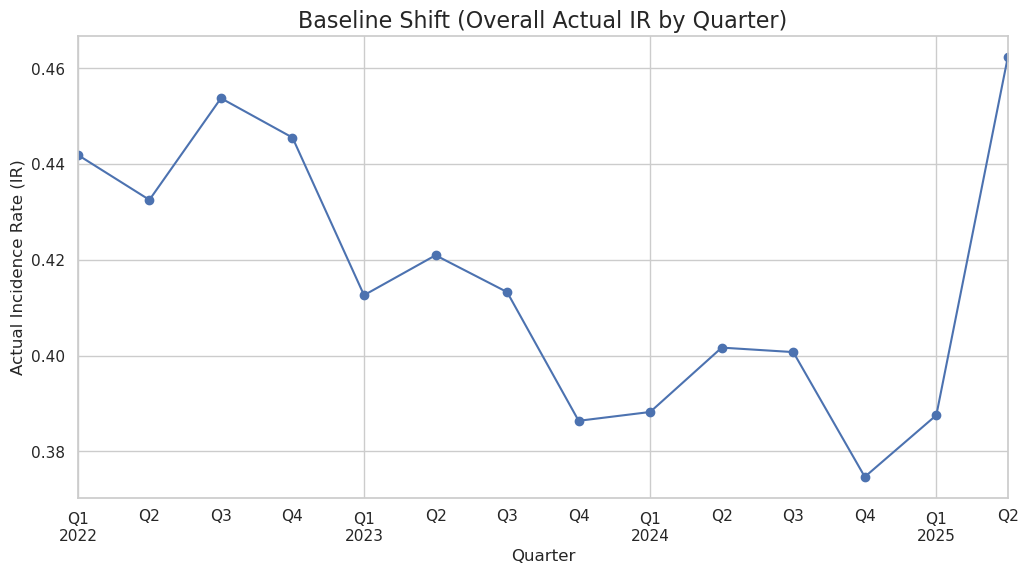

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

print("Filtering data from Jan 2022 to Apr 2025...")
analysis_start_date = '2022-01-01'
analysis_end_date = '2025-04-30'

df_cleaned['policy_start_date'] = pd.to_datetime(df_cleaned['policy_start_date'])

df_analysis_filtered = df_cleaned[
    (df_cleaned['policy_start_date'] >= analysis_start_date) &
    (df_cleaned['policy_start_date'] <= analysis_end_date)
].copy()

print(f"New shape: {df_analysis_filtered.shape}")
df_time = df_analysis_filtered.set_index('policy_start_date')

# Baseline Shift (P(y))
print("\n Baseline Shift (Overall Risk)")
q_baseline = df_time.resample('Q').agg(
actual_count=('od_claim_count', 'sum'),
exposure=('exposure', 'sum')
)
q_baseline = q_baseline[q_baseline['exposure'] > 0]
q_baseline['Actual IR'] = q_baseline['actual_count'] / q_baseline['exposure']

print(q_baseline[['Actual IR']])

plt.figure(figsize=(12, 6))
q_baseline['Actual IR'].plot(marker='o', linestyle='-')
plt.title('Baseline Shift (Overall Actual IR by Quarter)', fontsize=16)
plt.ylabel('Actual Incidence Rate (IR)')
plt.xlabel('Quarter')
plt.show()

In [4]:
# 2. Time-Based Data Splitting

TRAIN_START = '2022-01-01'
TRAIN_END = '2024-08-31'
TEST_START = '2024-09-01'
TEST_END = '2024-12-31'
OOT_START = '2025-01-01'
OOT_END = '2025-03-31'

# Create the sets
train_df = df_cleaned[
    (df_cleaned[DATE_COL] >= TRAIN_START) &
    (df_cleaned[DATE_COL] <= TRAIN_END)
].copy()

test_df = df_cleaned[
    (df_cleaned[DATE_COL] >= TEST_START) &
    (df_cleaned[DATE_COL] <= TEST_END)
].copy()

oot_df = df_cleaned[
    (df_cleaned[DATE_COL] >= OOT_START) &
    (df_cleaned[DATE_COL] <= OOT_END)
].copy()

print(f"  Train set shape: {train_df.shape} (Dates: {train_df[DATE_COL].min().date()} to {train_df[DATE_COL].max().date()})")
print(f"  Test set shape: {test_df.shape} (Dates: {test_df[DATE_COL].min().date()} to {test_df[DATE_COL].max().date()})")
print(f"  OOT set shape:   {oot_df.shape} (Dates: {oot_df[DATE_COL].min().date()} to {oot_df[DATE_COL].max().date()})")

  Train set shape: (50031, 19) (Dates: 2022-01-01 to 2024-08-31)
  Test set shape: (8614, 19) (Dates: 2024-09-01 to 2024-12-31)
  OOT set shape:   (5809, 19) (Dates: 2025-01-01 to 2025-03-31)


In [5]:
# 3. Model Training (LightGBM Poisson Regressor)

# Prepare data splits
X_train, y_train, w_train = train_df[features], train_df[TARGET], train_df[WEIGHT]
X_test, y_test, w_test = test_df[features], test_df[TARGET], test_df[WEIGHT]
X_oot, y_oot, w_oot = oot_df[features], oot_df[TARGET], oot_df[WEIGHT]

lgb_params = {
    'objective': 'poisson',
    'metric': 'poisson',
    'n_estimators': 4000,         
    'learning_rate': 0.01,       
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'num_leaves': 20,            
    'min_data_in_leaf': 500,     
    'n_jobs': -1,
    'seed': 42,
    'boosting_type': 'gbdt',
}

print("\nTraining LightGBM model...")

model = lgb.LGBMRegressor(**lgb_params)

model.fit(
    X_train, y_train,
    sample_weight=w_train,
    eval_set=[(X_test, y_test)],
    eval_sample_weight=[w_test],
    eval_metric='poisson',
    callbacks=[lgb.early_stopping(150, verbose=100)],
    categorical_feature=categorical_features
)

print("Model training complete.")

# Prediction
print("Generating predictions...")
pred_train = model.predict(X_train) 
pred_test = model.predict(X_test) 
pred_oot = model.predict(X_oot)


Training LightGBM model...
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-cho

In [6]:
# 4. Decile Analysis Function

def create_decline_analysis(y_true, y_pred_count, exposure, set_name):
    print(f"\n Decile Analysis: {set_name} Set")
    
    eval_df = pd.DataFrame({
        'actual_count': y_true,
        'predicted_count': y_pred_count,
        'exposure': exposure
    })
    eval_df = eval_df[eval_df['exposure'] > 0].copy()

    overall_actual_ir = eval_df['actual_count'].sum() / eval_df['exposure'].sum()
    overall_pred_ir = eval_df['predicted_count'].sum() / eval_df['exposure'].sum()

    eval_df['predicted_ir_record'] = eval_df['predicted_count'] / eval_df['exposure']
    
    eval_df['decile'] = pd.qcut(eval_df['predicted_ir_record'], 10, labels=False, duplicates='drop')

    decile_groups = eval_df.groupby('decile')
    
    decile_summary = pd.DataFrame({
        'Policies': decile_groups.size(),
        'Total Exposure': decile_groups['exposure'].sum(),
        'Actual Claims': decile_groups['actual_count'].sum(),
        'Predicted Claims': decile_groups['predicted_count'].sum()
    })
    
    # Calculate unformatted metrics
    decile_summary['Actual IR'] = decile_summary['Actual Claims'] / decile_summary['Total Exposure']
    decile_summary['Predicted IR'] = decile_summary['Predicted Claims'] / decile_summary['Total Exposure']
    decile_summary['Delta'] = decile_summary['Actual IR'] - decile_summary['Predicted IR']

    # Calculate Lift
    if overall_actual_ir > 0:
        decile_summary['Lift'] = decile_summary['Actual IR'] / overall_actual_ir
    
    top_decile_lift = decile_summary.loc[9, 'Lift']
    top_decile_ir = decile_summary.loc[9, 'Actual IR']
    bottom_decile_ir = decile_summary.loc[0, 'Actual IR']

    if bottom_decile_ir > 0:
        top_to_bottom_ratio = top_decile_ir / bottom_decile_ir
    else:
        top_to_bottom_ratio = np.nan

    mean_abs_delta = (decile_summary['Actual IR'] - decile_summary['Predicted IR']).abs().mean() * 100

    format_cols_pct = ['Actual IR', 'Predicted IR', 'Delta']
    for col in format_cols_pct:
        decile_summary[col] = (decile_summary[col] * 100).map('{:,.2f}%'.format)

    decile_summary['Lift'] = decile_summary['Lift'].map('{:,.2f}'.format)

    display_cols = ['Policies', 'Actual IR', 'Predicted IR', 'Delta']
    print(decile_summary[display_cols])
    
    print(f"\nOverall Actual IR:    {overall_actual_ir:.4%}")
    print(f"Overall Predicted IR: {overall_pred_ir:.4%}")
    print(f"Mean Absolute Delta:  {mean_abs_delta:.4f}%")
    
    print(f"Lift:  {top_to_bottom_ratio:.2f}x")
    
    return mean_abs_delta

# 5. Run Analysis & Report
create_decline_analysis(y_train, pred_train, w_train, "Train")
create_decline_analysis(y_test, pred_test, w_test, "Test")
create_decline_analysis(y_oot, pred_oot, w_oot, "OOT")


 Decile Analysis: Train Set
        Policies Actual IR Predicted IR   Delta
decile                                         
0           5004    17.81%       22.54%  -4.73%
1           5003    24.78%       28.87%  -4.10%
2           5003    31.28%       32.22%  -0.94%
3           5003    33.30%       35.08%  -1.78%
4           5003    36.89%       37.79%  -0.90%
5           5003    39.97%       40.76%  -0.80%
6           5003    45.20%       44.29%   0.91%
7           5004    47.46%       48.72%  -1.25%
8           5003    58.62%       54.82%   3.80%
9           5002    78.20%       68.29%   9.91%

Overall Actual IR:    41.3488%
Overall Predicted IR: 41.3372%
Mean Absolute Delta:  2.9111%
Lift:  4.39x

 Decile Analysis: Test Set
        Policies Actual IR Predicted IR    Delta
decile                                          
0            862    23.92%       23.63%    0.28%
1            861    28.20%       30.77%   -2.57%
2            861    31.73%       34.83%   -3.09%
3            862

27.538087101831998

In [7]:
# 6. Post-Model Analysis
def create_feature_level_analysis(X_data, y_true, y_pred_count, exposure, model, set_name):

    print(f"\n Feature-Level Analysis: {set_name} Set")
    
    eval_df = X_data.copy()
    eval_df['actual_count'] = y_true
    eval_df['predicted_count'] = y_pred_count
    eval_df['exposure'] = exposure
    
    eval_df = eval_df[eval_df['exposure'] > 0].copy()
        
    try:
        top_features = model.booster_.feature_name()[:25]
        print(f"Analyzing features: {top_features}")
    except Exception as e:
        print(f"Couldn't get feature names, skipping: {e}")
        return

    for col in top_features:
        if col not in eval_df.columns:
            print(f"Skipping '{col}', not in X_data.")
            continue
            
        print(f"\nAnalyzing Feature: '{col}'")
        
        feature_data = eval_df[col]
        if feature_data.isnull().any():
            if feature_data.dtype.name == 'category':
                feature_data = feature_data.cat.add_categories('NaN').fillna('NaN')
            else:
                feature_data = feature_data.fillna('NaN')
                
        groups = eval_df.groupby(feature_data)
        
        summary_df = pd.DataFrame({
            'Policies': groups.size(),
            'Total Exposure': groups['exposure'].sum(),
            'Actual Claims': groups['actual_count'].sum(),
            'Predicted Claims': groups['predicted_count'].sum()
        })
        
        summary_df['Actual IR'] = summary_df['Actual Claims'] / summary_df['Total Exposure']
        summary_df['Predicted IR'] = summary_df['Predicted Claims'] / summary_df['Total Exposure']
        summary_df['Delta'] = summary_df['Actual IR'] - summary_df['Predicted IR']
        
        summary_df = summary_df.sort_values(by='Policies', ascending=False)
        
        format_cols_pct = ['Actual IR', 'Predicted IR', 'Delta']
        for pct_col in format_cols_pct:
            summary_df[pct_col] = (summary_df[pct_col] * 100).map('{:,.2f}%'.format)

        with pd.option_context('display.max_rows', 25):
             print(summary_df[['Policies', 'Actual IR', 'Predicted IR', 'Delta']].head(25))
        
        if len(summary_df) > 20:
            print(f"  ... (and {len(summary_df) - 20} more values)")

# Run analysis on OOT set
print("\n Feature-Level Analysis on OOT Set...")
create_feature_level_analysis(
    X_oot, 
    y_oot, 
    pred_oot, 
    w_oot, 
    model, 
    "OOT"
)


 Feature-Level Analysis on OOT Set...

 Feature-Level Analysis: OOT Set
Analyzing features: ['experian_rank_final', 'variant_bracket_mapped', 'cc_group_ordinal', 'hit_flag_service', 'personal_loan_flag', 'embedded_red_flag', 'corrected_body_type', 'fuel_type', 'transmission_type', 'city_mapped', 'Product_Type2', 'make_mapped', 'cc_group', 'customer_age_group', 'Product_Plan', 'recommended_idv_grouped']

Analyzing Feature: 'experian_rank_final'
                     Policies Actual IR Predicted IR    Delta
experian_rank_final                                          
7.0000                   1887    36.66%       58.28%  -21.62%
5.0000                   1459    41.33%       73.43%  -32.09%
6.0000                   1251    38.69%       66.08%  -27.39%
 NaN                      443    33.33%       54.59%  -21.26%
4.0000                    423    42.25%       73.55%  -31.29%
3.0000                    329    42.46%       77.78%  -35.32%
2.0000                     17    37.29%       95.49%  -